In [1]:
import math
import random
import time
import pdb

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [2]:
from policies.pytorch_custom_lstm import LayerNormLSTMCell, test_script_stacked_lnlstm
test_script_stacked_lnlstm(5, 2, 3, 7, 4)

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/jit/_recursive.py:165: UserWarning: 'layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))


In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [4]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [5]:
from stable_baselines.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines.common.cmd_util import make_vec_env

from envs.Collins2018 import Collins2018Task

num_envs = 2
env = Collins2018Task(num_objects=(3, 6), num_actions=3, num_repeats=13)
envs = make_vec_env(lambda: env, n_envs=num_envs)


/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/

<h2>Neural Network</h2>

In [6]:
class A2C_LSTM(nn.Module):
    """Container Module with a LSTM layer leading to an action and value network module."""
    
    def __init__(self, num_inputs, num_outputs, num_LSTM):
        super().__init__()
        self.rnn = LayerNormLSTMCell(num_inputs, num_LSTM)
        self.actor = nn.Sequential(
            nn.Linear(num_LSTM, num_outputs),
            nn.LogSoftmax(dim=-1)
        )
        self.critic = nn.Linear(num_LSTM, 1)
        
        self.num_LSTM = num_LSTM
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        
        self.init_weights()
        
    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        value = self.critic(output)
        action_log_prob = self.actor(output)
        action_prob = Categorical(logits=action_log_prob)
        return action_prob, value, hidden
        
    def init_weights(self):
        init_scale = 1.4
        self.actor[0].weight.data.uniform_(-init_scale, init_scale)
        self.actor[0].bias.data.zero_()
        self.critic.weight.data.uniform_(-init_scale, init_scale)
        self.critic.bias.data.zero_()
        
    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return (
            weight.new_zeros(batch_size, num_LSTM),
            weight.new_zeros(batch_size, num_LSTM)
        )

In [7]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = envs.reset()
    if vis: envs.render()
    done = [False] * num_envs
    total_reward = 0
    hidden = model.init_hidden(1)
    
    while not any(done):
        state = torch.FloatTensor(state).to(device)
        dist, _, hidden = model(state, hidden)
        
        next_state, reward, done, _ = envs.step(dist.sample().cpu().numpy())
        state = next_state
        if vis: envs.render()
        total_reward += reward
    return total_reward

<h1>A2C: Synchronous Advantage Actor Critic</h1>
<h3><a href="https://blog.openai.com/baselines-acktr-a2c/#a2canda3c">OpenAI Blog:</a></h3>
<p>The Asynchronous Advantage Actor Critic method (A3C) has been very influential since the paper was published. The algorithm combines a few key ideas:</p>

<ul>
    <li>An updating scheme that operates on fixed-length segments of experience (say, 20 timesteps) and uses these segments to compute estimators of the returns and advantage function.</li>
    <li>Architectures that share layers between the policy and value function.</li>
    <li>Asynchronous updates.</li>
</ul>

<p>After reading the paper, AI researchers wondered whether the asynchrony led to improved performance (e.g. “perhaps the added noise would provide some regularization or exploration?“), or if it was just an implementation detail that allowed for faster training with a CPU-based implementation.</p>

<p>As an alternative to the asynchronous implementation, researchers found you can write a synchronous, deterministic implementation that waits for each actor to finish its segment of experience before performing an update, averaging over all of the actors. One advantage of this method is that it can more effectively use of GPUs, which perform best with large batch sizes. This algorithm is naturally called A2C, short for advantage actor critic. (This term has been used in several papers.)</p>

In [8]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [9]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.n

#Hyper params:
num_LSTM = 20
lr          = 7e-4
num_steps   = 5
batch_size = 1

model = A2C_LSTM(num_inputs, num_outputs, num_LSTM).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=lr)

In [10]:
max_frames   = 20_000_000
frame_idx    = 0
test_rewards = []

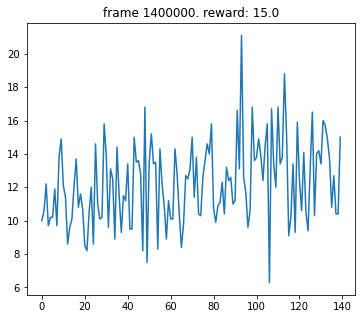

at frame 1400000,	 takes time 1621.03 seconds


KeyboardInterrupt: 

In [11]:
t_record = time.time()

while frame_idx < max_frames:

    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = []
    
    done = [False] * num_envs
    state = envs.reset()
    hidden = model.init_hidden(batch_size)

    while not any(done):
        state = torch.FloatTensor(state).to(device)
        dist, value, hidden = model(state, hidden)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action).unsqueeze(1)
        
        entropy.append(dist.entropy().unsqueeze(1))
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 10000 == 0:
            test_reward = np.mean([test_env() for _ in range(5)])
            test_rewards.append(test_reward)
            print(f'at frame {int(frame_idx)},\t mean testing reward {test_reward :.2f}')
            
        if frame_idx % 100000 == 0:
            plot(frame_idx, test_rewards)
            print(f'at frame {int(frame_idx)},\t takes time {(time.time() - t_record) :.2f} seconds')
            
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value, _ = model(next_state, hidden)
    returns = compute_returns(next_value, rewards, masks, gamma=0.9)
    
    log_probs = torch.cat(log_probs)
    returns   = torch.cat(returns).detach()
    values    = torch.cat(values)
    entropy = torch.cat(entropy).mean()
    
    advantage = returns - values
    actor_loss  = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    
    loss = actor_loss + 0.05 * critic_loss - 0.05 * entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()